In [2]:
%matplotlib inline
import torch
import random
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split



data = sio.loadmat('../SBSB_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')


class AccZDataset(Dataset):
    def __init__(self,start_no,range_len):
        data = sio.loadmat('../SBSB_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')
        self.start_no = start_no
        self.range_len = range_len
        self.data_set = data['L23MatChunk']
        self.n_trails = len(self.data_set)
        self.train_set = np.zeros((1,50000))
        
        for i in range (0,self.n_trails):
            curr = np.asarray(self.data_set[i][0][0][self.start_no : self.start_no+self.range_len]).reshape(1,self.range_len)
            self.train_set = np.append(self.train_set, curr, axis = 0)

        self.train_set = np.delete(self.train_set, (0), axis=0) #array of 20 * 50000
        
        labels = []
        for i in range(0, self.n_trails):
            if(i < 10):
                labels.append(0)
            else:
                labels.append(1)
        
        labels = np.asarray(labels).reshape(self.n_trails,1)
        self.train_set = np.append(self.train_set, labels, axis = 1)
        print(self.train_set.shape)
    def __len__(self):
        return len(self.train_set)

    def __getitem__(self, idx):
        
        sample = self.train_set[idx][:-1]
        label = self.train_set[idx][-1]

        return sample, label 



dataset = AccZDataset(20,50000)
real_value, real_label = dataset[13]
print(real_value)
print(real_value.shape)
print(real_label)




(20, 50001)
[0.04913539 0.0478669  0.05771144 ... 0.16863332 0.05331072 0.04423187]
(50000,)
1.0


In [4]:
#DATASET PREPERATION


data = sio.loadmat('../SBSB_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')
start_no = 0
range_len = 50000
data_set = data['L23MatChunk']
n_trials = len(data_set)
total_set = np.zeros((1,50000))

for i in range (20):

    curr = np.asarray(data_set[i][0][0][start_no : start_no+range_len]).reshape(1,range_len)
    total_set = np.append(total_set, curr, axis = 0)

total_set = np.delete(total_set, (0), axis=0) 

labels = []
for i in range(0, n_trials):
    if(i < 10):
        labels.append(0)
    else:
        labels.append(1)

labels = np.asarray(labels).reshape(n_trials,1)
total_set = np.append(total_set, labels, axis = 1)
print(total_set.shape)
targets_numpy = total_set[:,-1]
features_numpy = total_set[:,:-1]



(20, 50001)


In [5]:
vw_data = sio.loadmat('../VWVW_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')
vw_start_no = 0
vw_range_len = 50000
vw_data_set = data['L23MatChunk']
vw_n_trials = len(data_set)
vw_total_set = np.zeros((1,50000))

for i in range (20):

    vw_curr = np.asarray(vw_data_set[i][0][0][vw_start_no : vw_start_no + vw_range_len]).reshape(1,vw_range_len)
    vw_total_set = np.append(vw_total_set, vw_curr, axis = 0)

vw_total_set = np.delete(vw_total_set, (0), axis=0) 

vw_labels = []
for i in range(0, vw_n_trials):
    if(i < 10):
        vw_labels.append(0)
    else:
        vw_labels.append(1)

vw_labels = np.asarray(vw_labels).reshape(vw_n_trials,1)
vw_total_set = np.append(vw_total_set, vw_labels, axis = 1)
print(vw_total_set.shape)
vw_targets_numpy = vw_total_set[:,-1]
vw_features_numpy = vw_total_set[:,:-1]

(20, 50001)


In [7]:
#DATA AUGMENTATION
#SINGLE KERNEL 

# import axangles
from scipy.interpolate import CubicSpline
from transforms3d.axangles import axangle2mat

features_numpy_new = features_numpy.T

print('Original FeaturesNumpy Database')
print(features_numpy.shape)
print('Original TargetsNumpy Database')
print(targets_numpy.shape)


#perform jittering
def DA_Jitter(X, sigma= 0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

#perform scaling
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

#perform magnitude warping 
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    return np.array([cs_x(x_range)]).transpose()

def DA_MagWarp(X, sigma):
    return X * GenerateRandomCurves(X, sigma)

#performing Rotation
percent_value = 1
percent_shift = (range_len / 100) * percent_value
def DA_Rotation(X):
    shift = np.random.randint(low=0 , high = percent_shift) #giving percent_value shift (if percent_value is 1, then 1% shift)
    return np.roll(X, shift)




#implement jittering
n_sets_jitter = 22
sigma = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,0.5,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,0.31,0.57]
#number of values in sigma list should match the n_sets_jitter value
for j in range (n_sets_jitter):
    for i in range(20):
        features_numpy = np.append(features_numpy, DA_Jitter(features_numpy_new[:,i], sigma[j]).reshape(1,-1), axis = 0)
    targets_numpy = np.append(targets_numpy, targets_numpy[0:20], axis = 0)



print('FeaturesNumpy Output shape after jittering')
print(features_numpy.shape)
print('TargetsNumpy Output shape after jittering')
print(targets_numpy.shape)

# #implement scaling
# features_numpy_new = features_numpy.T
# n_sets_scaling = 22
# sigma = [0.2,0.5,0.3,0.4,0.2,0.6,0.8,0.9,0.1,0.7,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,0.31,0.57,0.73]


# for j in range (n_sets_scaling):
#     for i in range(20):
#         features_numpy = np.append(features_numpy, DA_Scaling(features_numpy_new[:,0].reshape(-1,1), sigma[j]).reshape(1,-1), axis = 0)
#     targets_numpy = np.append(targets_numpy, targets_numpy[0:20], axis = 0)
    

# print('FeaturesNumpy Output shape after scaling')
# print(features_numpy.shape)
# print('TargetsNumpy Output shape after scaling')
# print(targets_numpy.shape)


#implement magnitude warping
features_numpy_new = features_numpy.T
n_sets_magwarp = 22
sigma = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,0.5,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,0.31,0.57]
#number of values in sigma list should match the n_sets_jitter value
for j in range (n_sets_magwarp):
    for i in range(20):
        features_numpy = np.append(features_numpy, DA_MagWarp(features_numpy_new[:,i].reshape(-1,1), sigma[j]).reshape(1,-1), axis = 0)
    targets_numpy = np.append(targets_numpy, targets_numpy[0:20], axis = 0)



print('FeaturesNumpy Output shape after magwarping')
print(features_numpy.shape)
print('TargetsNumpy Output shape after magwarping')
print(targets_numpy.shape)

#implement Rotation
features_numpy_new = features_numpy.T
n_sets_rotation = 22


print(DA_Rotation(features_numpy_new[:,i].reshape(-1,1)).reshape(1,-1))

for j in range (n_sets_rotation):
    for i in range(20):
        features_numpy = np.append(features_numpy, DA_Rotation(features_numpy_new[:,i].reshape(-1,1)).reshape(1,-1), axis = 0)
    targets_numpy = np.append(targets_numpy, targets_numpy[0:20], axis = 0)


print('FeaturesNumpy Output shape after rotation')
print(features_numpy.shape)
print('TargetsNumpy Output shape after rotation')
print(targets_numpy.shape)


Original FeaturesNumpy Database
(20, 50000)
Original TargetsNumpy Database
(20,)
FeaturesNumpy Output shape after jittering
(460, 50000)
TargetsNumpy Output shape after jittering
(460,)
FeaturesNumpy Output shape after magwarping
(900, 50000)
TargetsNumpy Output shape after magwarping
(900,)
[[1.22414497 1.22158544 1.24027217 ... 1.25914105 1.24361916 1.24150394]]
FeaturesNumpy Output shape after rotation
(1340, 50000)
TargetsNumpy Output shape after rotation
(1340,)


In [13]:
#TRAIN AND TEST SPLIT


features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)



featuresTrain = torch.from_numpy(features_train).type(torch.FloatTensor)
targetsTrain = torch.from_numpy(targets_train).type(torch.FloatTensor)

featuresTest = torch.from_numpy(features_test).type(torch.FloatTensor)
targetsTest = torch.from_numpy(targets_test).type(torch.FloatTensor)

vw_featuresTest = torch.from_numpy(features_test).type(torch.FloatTensor)
vw_targetsTest = torch.from_numpy(targets_test).type(torch.FloatTensor)

train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)
vw_test = torch.utils.data.TensorDataset(vw_featuresTest,vw_targetsTest)



batch_size = 16
batch_size_test = 4
batch_size_val = 4

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size_test, shuffle = False)
vw_test_loader = torch.utils.data.DataLoader(vw_test, batch_size = batch_size_val, shuffle = False)


print('Shape of Features Train Dataset')
print(featuresTrain.size())
print('Shape of Targets Train Dataset')
print(targetsTrain.size())
print('Shape of Features Test Dataset')
print(featuresTest.size())
print('Shape of Targets Test Dataset')
print(targetsTest.size())

Shape of Features Train Dataset
torch.Size([1072, 50000])
Shape of Targets Train Dataset
torch.Size([1072])
Shape of Features Test Dataset
torch.Size([268, 50000])
Shape of Targets Test Dataset
torch.Size([268])


In [14]:

#Designing the model

filters = 1

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = filters,kernel_size=25, stride=10),
            nn.ReLU(),
            nn.BatchNorm1d(filters))
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=10, stride=5),
            nn.ReLU(),
            nn.BatchNorm1d(filters))
        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=10, stride=3),
            nn.ReLU(),
            nn.BatchNorm1d(filters))
        self.avgLayer = nn.AvgPool1d(10, stride = 2)
        self.fc1 = nn.Linear(161,2)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out) 
        out = self.avgLayer(out)
        out = self.fc1(out)
        return out

    def init_hidden(self,batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return Variable(hidden)
    
    
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_uniform(m.weight.data, nn.init.calculate_gain('relu'))
        m.bias.data.zero_()
    

model = ConvNet()
optimizer = optim.SGD(model.parameters(), lr=0.2)
criterion = nn.CrossEntropyLoss()
model

ConvNet(
  (layer1): Sequential(
    (0): Conv1d(1, 1, kernel_size=(25,), stride=(10,))
    (1): ReLU()
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1d(1, 1, kernel_size=(10,), stride=(5,))
    (1): ReLU()
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv1d(1, 1, kernel_size=(10,), stride=(3,))
    (1): ReLU()
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avgLayer): AvgPool1d(kernel_size=(10,), stride=(2,), padding=(0,))
  (fc1): Linear(in_features=161, out_features=2, bias=True)
)

/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Current Epoch: 0
Current Batch Number: 1
Current Batch Number: 2
Current Batch Number: 3
Current Batch Number: 4
Current Batch Number: 5
Current Batch Number: 6
Current Batch Number: 7
Current Batch Number: 8
Current Batch Number: 9
Current Batch Number: 10
Current Batch Number: 11
Current Batch Number: 12
Current Batch Number: 13
Current Batch Number: 14
Current Batch Number: 15
Current Batch Number: 16
Current Batch Number: 17
Current Batch Number: 18
Current Batch Number: 19
Current Batch Number: 20
Current Batch Number: 21
Current Batch Number: 22
Current Batch Number: 23
Current Batch Number: 24
Current Batch Number: 25
Current Batch Number: 26
Current Batch Number: 27
Current Batch Number: 28
Current Batch Number: 29
Current Batch Number: 30
Current Batch Number: 31
Current Batch Number: 32
Current Batch Number: 33
Current Batch Number: 34
Current Batch Number: 35
Current Batch Number: 36
Current Batch Number: 37
Current Batch Number: 38
Current Batch Number: 39
Current Batch Num

/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 1  Loss: 0.02835977077484131  Accuracy: 54 %
Current Epoch: 1
Current Batch Number: 1
Current Batch Number: 2
Current Batch Number: 3
Current Batch Number: 4
Current Batch Number: 5
Current Batch Number: 6
Current Batch Number: 7
Current Batch Number: 8
Current Batch Number: 9
Current Batch Number: 10
Current Batch Number: 11
Current Batch Number: 12
Current Batch Number: 13
Current Batch Number: 14
Current Batch Number: 15
Current Batch Number: 16
Current Batch Number: 17
Current Batch Number: 18
Current Batch Number: 19
Current Batch Number: 20
Current Batch Number: 21
Current Batch Number: 22
Current Batch Number: 23
Current Batch Number: 24
Current Batch Number: 25
Current Batch Number: 26
Current Batch Number: 27
Current Batch Number: 28
Current Batch Number: 29
Current Batch Number: 30
Current Batch Number: 31
Current Batch Number: 32
Current Batch Number: 33
Current Batch Number: 34
Current Batch Number: 35
Current Batch Number: 36
Current Batch Number: 37
Current Bat

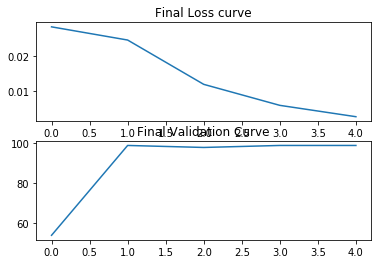

In [15]:
# #  training model 
model.apply(weights_init)
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
n_classes = 2
for epoch in range(num_epochs):
    print('Current Epoch: {}'.format(epoch))
    for i, (samples, targets) in enumerate(train_loader):
        
        print('Current Batch Number: {}'.format(i+1))
        train = Variable(samples.view(batch_size,1,-1))
        targets = Variable(targets.type(torch.LongTensor))
        

        # Clear gradients
        optimizer.zero_grad()
        
        #setting up model for training
        model.train()
        
        # Forward propagation
        outputs = model(train)
        outputs = outputs.reshape(batch_size,2)
        # Calculate softmax and cross entropy loss
        loss = criterion(outputs, targets)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
    count += 1
    #accuracy at the end of epoch    
    correct = 0
    total = 0
    # Predict test dataset
    for samples, labels in test_loader:

        test = Variable(samples.view(batch_size_test,1,-1))

        #setting up in test mode
        model.eval()
        # Forward propagation
        outputs = model(test)
        outputs = outputs.view(batch_size_test, n_classes)

        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1].type(torch.FloatTensor)

        # Total number of labels
        total += len(labels)

        # Total correct predictions
        correct += (predicted == labels).sum()

    accuracy = 100 * correct / float(total)

    loss_list.append(loss.data)
    iteration_list.append(count)
    accuracy_list.append(accuracy)
    print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data[0], accuracy))

plt.subplot(2,1,1)
plt.title('Final Loss curve')
plt.plot(loss_list)
plt.subplot(2,1,2)
plt.title('Final Validation Curve')
plt.plot(accuracy_list)

In [16]:


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


accuracy_list = []
f1_score_list = []
precision_list = []
recall_list = []
y_pred =[]
y_true = []


with torch.no_grad():
    for i, data in enumerate(vw_test_loader, 0):
            #test_loader has 4 * 50000 batches with 4 values of labels in each batch 
            #it has 67 such batches 
            samples, labels = data
            samples = Variable(samples.view(batch_size_val,1,-1))
            
            model.eval()
            
            outputs = model(samples)
            outputs = outputs.view(batch_size_val, n_classes)
            
            predictions = torch.argmax(outputs, 1)
            targets = labels
            
            y_pred.extend(predictions)
            y_true.extend(targets)
#             accuracy_list.append(accuracy_score(targets, predictions))
#             f1_score_list.append(f1_score(targets, predictions))
#             precision_list.append(precision_score(targets, predictions))
#             recall_list.append(recall_score(targets, predictions))



conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)
print("Accuracy Score: {}".format(accuracy_score(y_true, y_pred) * 100))
print("F1 Score: {}". format(f1_score(y_true, y_pred) * 100))
print("Precision Score: {}".format(precision_score(y_true, y_pred) * 100))
print("Recall Score: {}".format(recall_score(y_true, y_pred)* 100))
            
            


[[123   0]
 [  1 144]]
Accuracy Score: 99.6268656716418
F1 Score: 99.65397923875432
Precision Score: 100.0
Recall Score: 99.3103448275862


In [11]:
from sklearn.metrics import confusion_matrix
output = torch.randn(1, 2, 4, 4)
pred = torch.argmax(output, 1)
print(pred)
target = torch.empty(1, 4, 4, dtype=torch.long).random_(2)
print(target)
confusion_matrix(pred.view(-1), target.view(-1))

tensor([[[1, 0, 0, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 0],
         [1, 0, 1, 1]]])
tensor([[[0, 1, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 1],
         [1, 0, 1, 0]]])


array([[5, 4],
       [4, 3]])